In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.metrics import pairwise_distances

# I made the figure and but the aspect ratio was not correct
# rescale the numbers to keep look the same
height, width = 8.25, 4.45
r = height / width / 2


def gaussian(x, y):
    return np.exp(-(x**2) - y**2 * 2 * r)


# irregular function with multiple local optima
def func(x, y):
    optima = np.array(
        [
            (-4, 4),
            (-4.5, 4.5),
            (-3, 2),
            (-2, 3),
            (-1, 2),
            (0.5, 1.5),
            (0.5, 1.5),
            (1.5, 3),
            (2, 3.5),
            (2.5, 4),
            (-4, -3),
            (-4, -3),
            (-2.5, -2),
            (4, -3),
            (3, -3),
            (4, -2),
            (2, -1),
            (0, -4),
            (0, -4),
        ]
    )
    optima = optima / [1, 2 / r]
    return np.sum([gaussian(x - x0, y - y0) for x0, y0 in optima], axis=0)


# Generate x and y values
x = np.linspace(-5, 5, 100)
y = np.linspace(-2.5, 2.5, 100) / r
X, Y = np.meshgrid(x, y)

# Calculate function values
Z = func(X, Y)

In [8]:
r = 1.0

idx = np.where(Z > 1.25)
X_good = X[idx]
Y_good = Y[idx]

points = np.array([X_good, Y_good]).T

np.random.shuffle(points)

connectivity_matrix = (pairwise_distances(points) < r).astype(int)
connectivity_matrix = connectivity_matrix - np.eye(connectivity_matrix.shape[0])
G = nx.from_numpy_array(connectivity_matrix)

neighbour_dict = nx.to_dict_of_lists(G)

# neighbour_dict = {k: neighbour_dict[k] for k in shuffled_keys}

forbidden_nodes = set()
selected_nodes = set()
selected_nodes_list = []
forbidden_nodes_lists = []
for node, neighbours in neighbour_dict.items():
    if node in forbidden_nodes:
        continue
    selected_nodes.add(node)
    selected_nodes_list.append(node)
    just_forbidden = list((set(neighbours) - selected_nodes) - forbidden_nodes)
    forbidden_nodes.update(neighbours)
    forbidden_nodes_lists.append(just_forbidden)  # needed for plotting

selected_nodes = list(selected_nodes)
selected_points = points[selected_nodes]

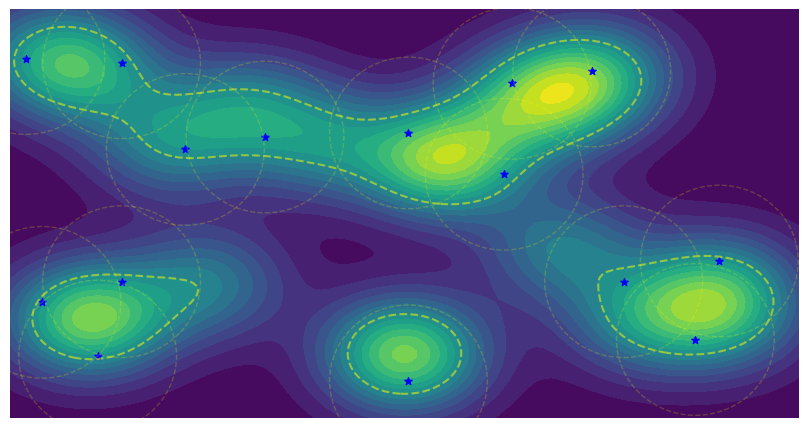

In [9]:
# Create filled contour plot

height, width = 8.25, 4.45
plt.figure(figsize=(height, width))

contour = plt.contourf(X, Y, Z, levels=20, cmap="viridis")
plt.contour(X, Y, Z, levels=[1.2], colors="yellow", linestyles="dashed", alpha=0.5)
plt.scatter(
    selected_points[:, 0],
    selected_points[:, 1],
    c="blue",
    s=30,
    marker="*",
    label="Selected Points",
)
# draw circles around selected points
for i, point in enumerate(selected_points):
    circle = plt.Circle(
        (point[0], point[1]), r, color="yellow", fill=False, alpha=0.2, ls="--"
    )
    plt.gca().add_artist(circle)

plt.axis("off")
plt.tight_layout()

(40, 2)
0.02901509862034774


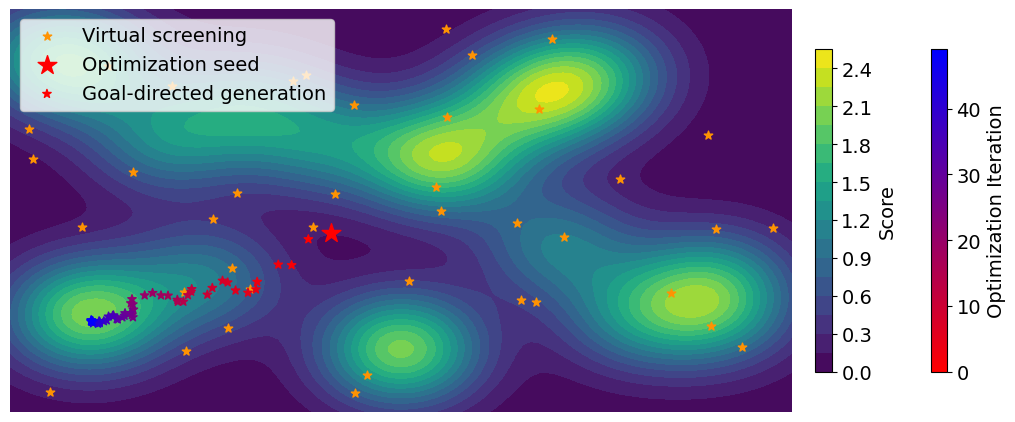

In [41]:
# Create filled contour plot
import matplotlib
import matplotlib.colors

matplotlib.rc("font", size=14)

s = 1
height, width = (8.25 + 3) * s, (4.45) * s
plt.figure(figsize=(height, width))

# set c map to be white at the minimum and red at the maximum
contour = plt.contourf(X, Y, Z, levels=20, cmap="viridis")

np.random.seed(3)
n_random = 40
x_random = np.random.uniform(-5, 5, 5000)
y_random = np.random.uniform(-2.5, 2.5, 5000) / r
random_points = np.array([x_random, y_random]).T
random_points_score = np.array([func(x, y) for x, y in random_points])
random_points = random_points[random_points_score < 600][:n_random]
random_points_score = random_points_score[random_points_score < 0.8][:n_random]
print(random_points.shape)
print(random_points_score.min())
plt.scatter(
    random_points[:, 0],
    random_points[:, 1],
    c="#FF9302",
    s=40,
    marker="*",
    label="Virtual screening",
)

colors = ["red", "green", "blue"]
# max_point = random_points[np.argmax(random_points_score[random_points_score < 0.8])]
max_point = (-0.9, -0.3)
max_point_initial = max_point
cmap_optimization = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["red", "blue"]
)

score = 0
n_iter = 50
n_try = 5

opt_trace = []
for i in range(n_iter):
    std = np.exp(-score / 1.1) * 0.2
    new_points = max_point + np.random.normal(0, std, (n_try, 2))
    label = "Goal-directed generation" if i == n_iter // 2 else None
    max_point = new_points[np.argmax([func(x, y) for x, y in new_points])]
    opt_trace.append(max_point)
    score = func(*max_point)


opt_trace = np.array(opt_trace)

opt_obj = plt.scatter(
    max_point_initial[0],
    max_point_initial[1],
    c="red",
    s=200,
    marker="*",
    label="Optimization seed",
)

scatter = plt.scatter(
    opt_trace[:, 0],
    opt_trace[:, 1],
    s=40,
    marker="*",
    label="Goal-directed generation",
    c=np.arange(len(opt_trace)),
    cmap=cmap_optimization,
)


plt.axis("off")
plt.colorbar(scatter, label="Optimization Iteration", shrink=0.8, pad=-0.025)
plt.colorbar(contour, label="Score", orientation="vertical", shrink=0.8, pad=0.025)
plt.legend(loc="upper left")

plt.tight_layout()

plt.savefig("../goal_directed_generation_vs.pdf", bbox_inches="tight")
plt.savefig("../goal_directed_generation_vs.png", dpi=300, bbox_inches="tight")